In [1]:
import numpy as np
import collections

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 300)

# Local imports
import tf_data
import tf_methods
import utils

def HaarMat(N):
    if N == 1: return np.array([[1]])
    H = 1/np.sqrt(2)*np.concatenate(
        (
            np.kron(HaarMat(N//2),[1,1])
        ,
            np.kron(np.identity(N//2),[1,-1])
        ),axis = 0
        )
    return H

def invHaarMat(N):
    return HaarMat(N).transpose()

In [2]:
n = 512
x = np.linspace(0, 1, n)
np.random.seed(100)

degrees = [0, 1, 2]
nknots  = 4
strue = 0.1
knots = np.linspace(0, 1, nknots+2)[1:-1]

data = dict()

for degree in degrees:
    bfix = np.random.normal(0, 1, size = nknots + degree)
    data[degree] = tf_data.changepoint_from_bspline(x, knots, strue, degree = degree, 
                        signal = "fixed", bfix = bfix, seed = 100, 
                        include_intercept = False)

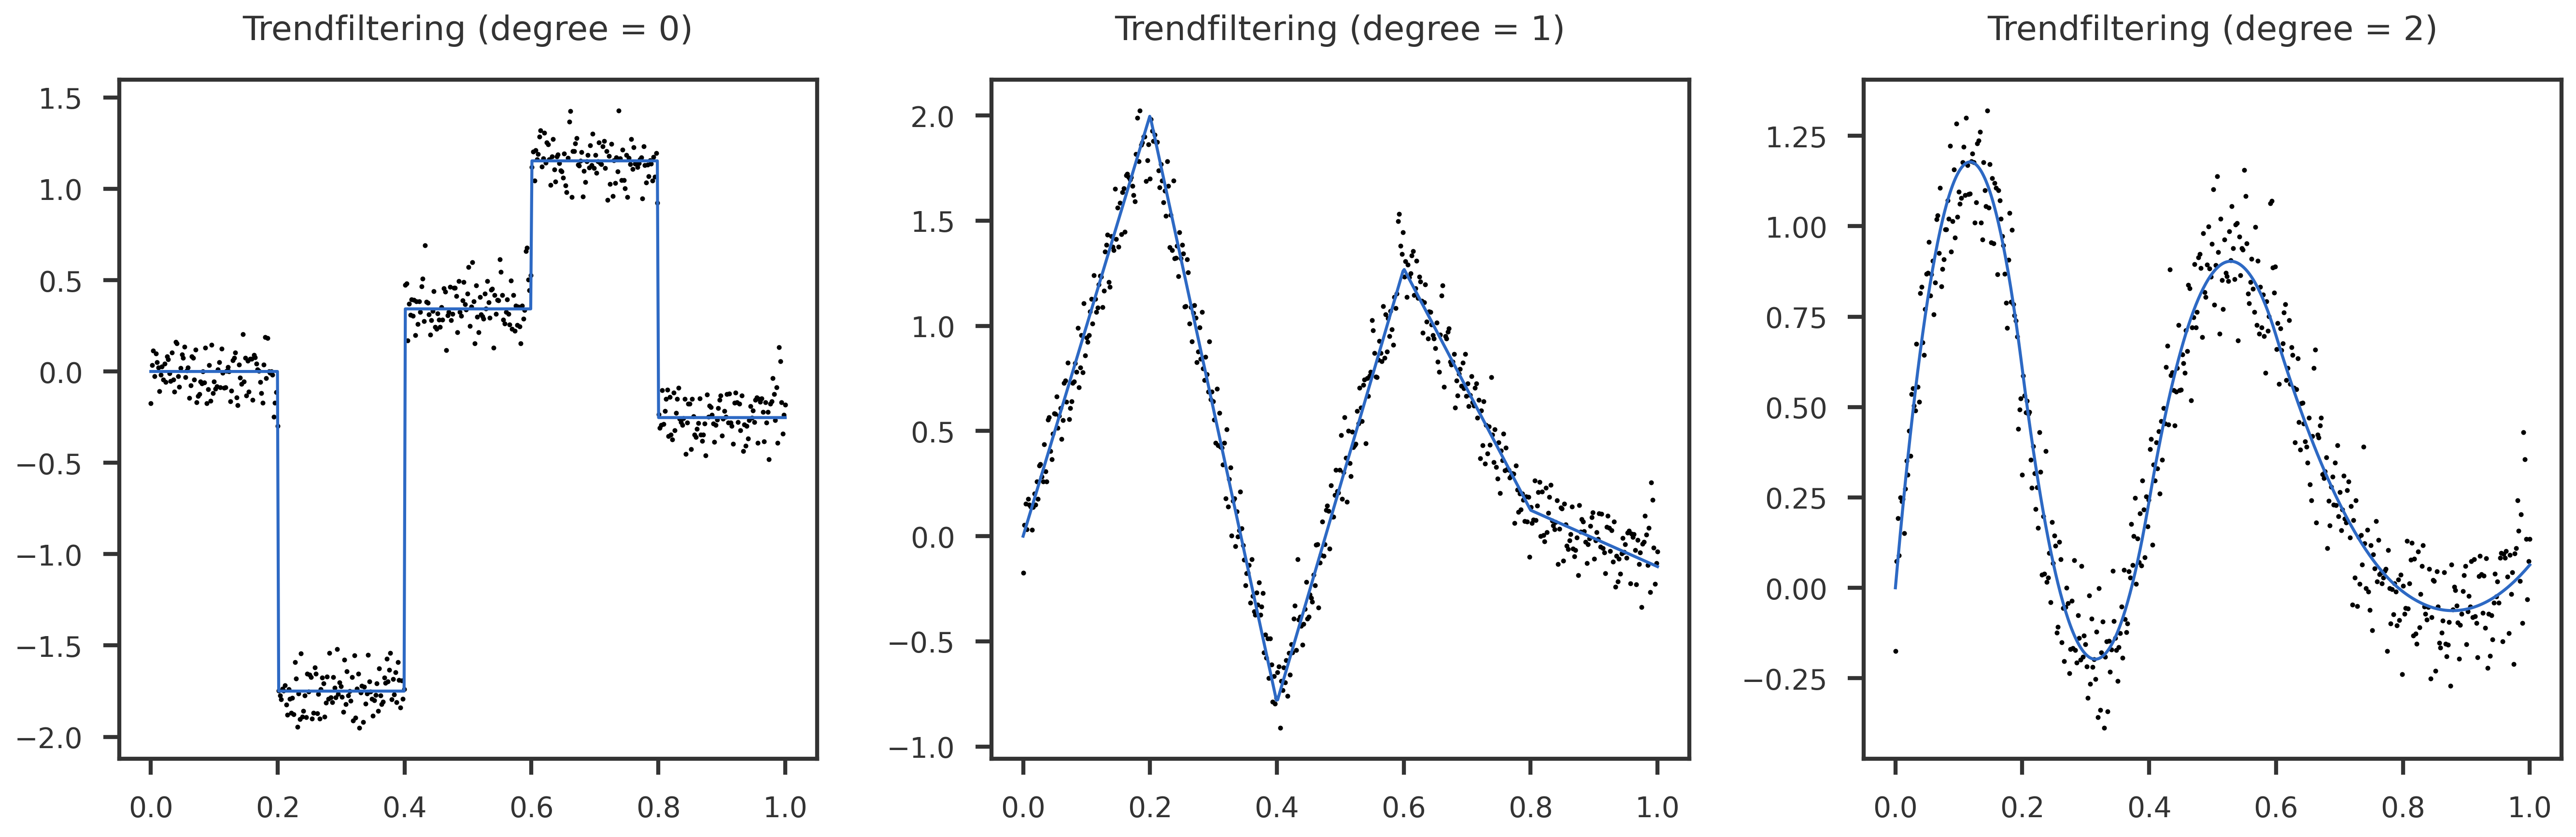

In [3]:
fig = plt.figure(figsize = (18, 6))
for i, d in enumerate(degrees):
    ax = fig.add_subplot(1, 3, i+1)
    ax.scatter(data[d].x, data[d].y, s = 2, color = 'black')
    ax.plot(data[d].x, data[d].ytrue)
    ax.set_title(f"Trendfiltering (degree = {d})", pad = 20)
fig.tight_layout()
fig.subplots_adjust(wspace=0.25)
plt.show()

In [86]:
methods = ['lasso', 'genlasso', 'gradvi', 'cavi', 'gradvi-wavelet']
method_colors = {
    'genlasso': "#93AA00",
    'gradvi': "#CC2529",
    'cavi': "#2D69C4",
    'lasso': "#FFB300",
    'gradvi-wavelet': '#6B4C9A',
    'gradvi-direct': '#535154'
}
res = {k:dict() for k in methods}

In [131]:
from gradvi.inference import WaveletRegression
from gradvi.models import basis_matrix
from gradvi.inference import LinearRegression
from gradvi.tests import toy_priors
from tf_methods import CRes

def _gradvi_trendfilter(y, degree, b0 = None, s0 = None, x0 = None):
    n    = y.shape[0]
    H    = basis_matrix.trendfiltering_scaled(n, degree)
    Hinv = basis_matrix.trendfiltering_inverse_scaled(n, degree)

    # Initialize
    if b0 is None:
        if x0 is None:
            print("GradVI: Running first pass for initialization")
            prior_init = toy_priors.get_ash_scaled(k = 10, sparsity = 0.9, skbase = (degree + 1) * 30)
            gv1 = LinearRegression(optimize_s = False, maxiter = 1000, fit_intercept = False, obj = 'direct', tol = 1e-7)
            gv1.fit(H, y, prior_init, s2_init = 0.001)
            b0 = gv1.coef
            #prior = gv1.prior
        else:
            b0 = np.dot(Hinv, x0)

    if x0 is None:
        x0 = np.dot(H, b0)

    if s0 is None:
        s0 = np.var(y - x0)

    # Run 
    prior = toy_priors.get_ash_scaled(k = 10, sparsity = 0.9, skbase = (degree + 1) * 2)
    gv2 = LinearRegression(maxiter = 10000, obj = 'reparametrize', tol = 1e-8)
    gv2.fit(H, y, prior, b_init = b0, s2_init = s0)

    # Result
    coef = gv2.coef
    yest = np.dot(H, coef) + gv2.intercept
    return CRes(y = yest, coef = coef, s2 = gv2.residual_var, prior = gv2.prior, obj = gv2)


def _gradvi_trendfilter_direct(y, degree, b0 = None, s0 = None, x0 = None):
    n    = y.shape[0]
    H    = basis_matrix.trendfiltering_scaled(n, degree)
    Hinv = basis_matrix.trendfiltering_inverse_scaled(n, degree)
    
    # Initialize
    if b0 is None:
        if x0 is None:
            print("GradVI direct: Running first pass for initialization")
            prior_init = toy_priors.get_ash_scaled(k = 10, sparsity = 0.9, skbase = (degree + 1) * 30)
            gv1 = LinearRegression(optimize_s = False, maxiter = 2000, fit_intercept = False, obj = 'direct', tol = 1e-7)
            gv1.fit(H, y, prior_init, s2_init = 0.001)
            b0 = gv1.coef
            #prior = gv1.prior
        else:
            b0 = np.dot(Hinv, x0)

    if x0 is None:
        x0 = np.dot(H, b0)

    if s0 is None:
        s0 = np.var(y - x0)
        
    prior = toy_priors.get_ash_scaled(k = 10, sparsity = 0.9, skbase = (degree + 1) * 2)  
    gv2 = LinearRegression(maxiter = 10000, obj = 'direct', tol = 1e-8, invert_method = 'trisection')
    gv2.fit(H, y, prior, b_init = b0, s2_init = s0)
    
    
    # Result
    coef = gv2.coef
    yest = np.dot(H, coef) + gv2.intercept
    return CRes(y = yest, coef = coef, s2 = gv2.residual_var, prior = gv2.prior, obj = gv2)


def _gradvi_wavelet_trendfilter(y, degree, x0 = None, s0 = None, b0 = None, 
                                maxcor = 10, maxiter = 10000, maxls = 20):
    n = y.shape[0]
    H    = basis_matrix.trendfiltering_scaled(n, degree)
    Hinv = basis_matrix.trendfiltering_inverse_scaled(n, degree)
    dj   = np.sum(np.square(H), axis = 0)

    # Run
    prior = toy_priors.get_ash_scaled(k = 10, sparsity = 0.9, skbase = (degree + 1) * 2.)
    gv1 = WaveletRegression(maxiter = maxiter, tol = 1e-8, optimize_s = True,
                            optimize_w = True, optimize_b = False,
                            options = {'maxcor': maxcor, 'disp': True, 'maxls': maxls})
    gv1.fit(Hinv, y, prior, x_init = x0, dj = dj)

    # Result
    coef = gv1.coef
    yest = gv1.signal
    return CRes(y = yest, coef = coef, s2 = gv1.residual_var, prior = gv1.prior, obj = gv1)

In [132]:
from gradvi.optimize.moving_average import moving_average

dk = 2
method = 'gradvi-wavelet'

x0 = moving_average(data[dk].y, n = 40)
s2_init = np.var(data[dk].y - x0)

gv1 = _gradvi_wavelet_trendfilter(data[dk].y, dk, x0 = x0, s0 = s2_init, 
                                  maxcor = 10, maxiter = 1000, maxls = 1000)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.78694D+07    |proj g|=  2.26666D+09

At iterate    1    f=  3.41490D+05    |proj g|=  3.34165D+05

At iterate    2    f=  2.85391D+05    |proj g|=  2.32494D+05

At iterate    3    f=  2.07816D+05    |proj g|=  1.22191D+05

At iterate    4    f=  1.60065D+05    |proj g|=  7.17770D+04

At iterate    5    f=  1.20957D+05    |proj g|=  4.04162D+04

At iterate    6    f=  9.23283D+04    |proj g|=  2.31304D+04

At iterate    7    f=  7.04350D+04    |proj g|=  1.31515D+04

At iterate    8    f=  5.39225D+04    |proj g|=  7.49052D+03

At iterate    9    f=  4.12909D+04    |proj g|=  4.25374D+03

At iterate   10    f=  3.14655D+04    |proj g|=  2.40361D+03

At iterate   11    f=  2.37022D+04    |proj g|=  1.34583D+03

At iterate   12    f=  1.82973D+04    |proj g|=  7.69294D+02

At iterate   13    f=  1.4

In [26]:
gv2 = _gradvi_trendfilter_direct(data[dk].y, dk, x0 = x0, s0 = s2_init)

In [27]:
gv2.obj.niter

3744

In [30]:
gv3 = _gradvi_trendfilter(data[dk].y, dk, x0 = x0, s0 = s2_init)

In [32]:
gv3.obj.niter

4419

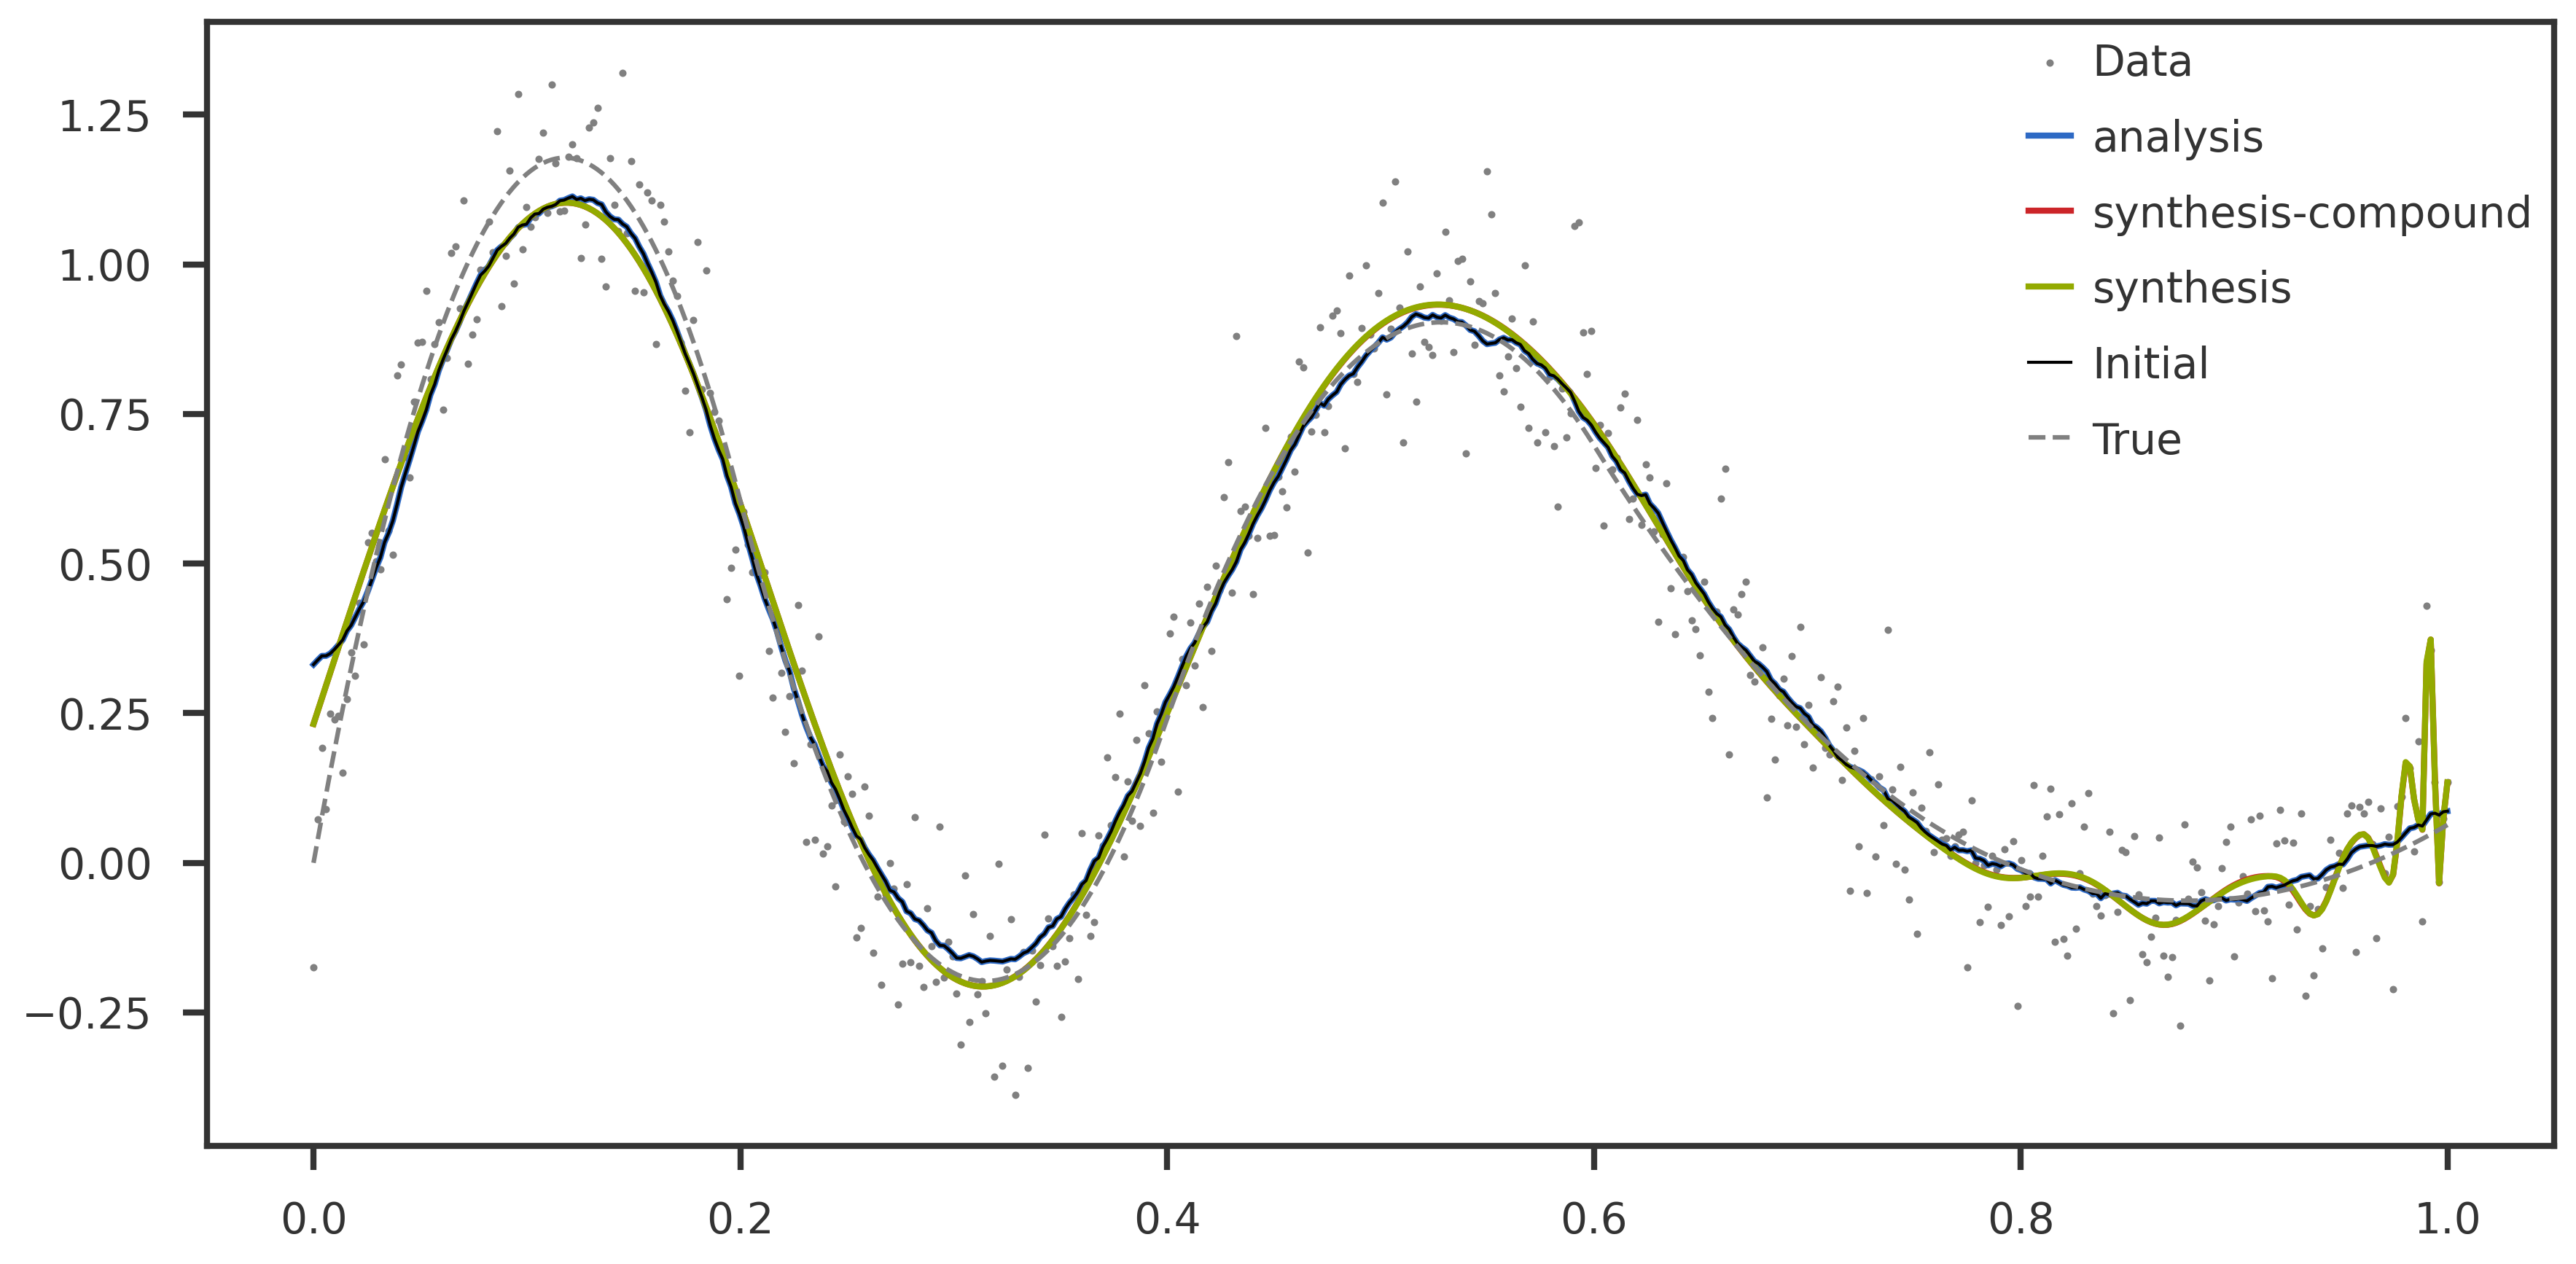

In [133]:
fig = plt.figure(figsize = (12, 6))
ax1 = fig.add_subplot(111)
#ax2 = fig.add_subplot(122)

m_btrue = data[dk].btrue

ax1.scatter(data[dk].x, data[dk].y, s= 2, label = 'Data', color = 'grey')
ax1.plot(data[dk].x, gv1.y, lw = 2, label = 'analysis')
ax1.plot(data[dk].x, gv2.y, lw = 2, label = 'synthesis-compound')
ax1.plot(data[dk].x, gv3.y, lw = 2, label = 'synthesis')
ax1.plot(data[dk].x, x0, lw = 1, label = 'Initial', color = 'black')

ax1.plot(data[dk].x, data[dk].ytrue, label = 'True', color = 'grey', ls = 'dashed')
ax1.legend()

#ax2.scatter(m_btrue, np.dot(Hinv, x0), label = 'Initial')
#ax2.scatter(m_btrue, gv1.coef, label = 'GradVI-wavelet')
#ax2.scatter(m_btrue, gv2.coef, label = 'GradVI-direct')
#ax2.scatter(m_btrue, gv3.coef, label = 'GradVI')

#ax2.legend()
#mpl_utils.plot_diag(ax2)

fig.tight_layout()
fig.subplots_adjust(wspace=0.25)
# utils.saveplot(fig, 'trendfiltering_simple_examples_wavelet_moving_average_init')
plt.show()

In [38]:
H = basis_matrix.trendfiltering_scaled(n, dk)

In [41]:
np.corrcoef(H)

array([[1.        , 0.99999947, 0.99999789, ..., 0.78770997, 0.77849745,
        0.71167129],
       [0.99999947, 1.        , 0.99999947, ..., 0.78779663, 0.77858791,
        0.71175902],
       [0.99999789, 0.99999947, 1.        , ..., 0.78788258, 0.77867768,
        0.71184613],
       ...,
       [0.78770997, 0.78779663, 0.78788258, ..., 1.        , 0.95491631,
        0.74838014],
       [0.77849745, 0.77858791, 0.77867768, ..., 0.95491631, 1.        ,
        0.8796099 ],
       [0.71167129, 0.71175902, 0.71184613, ..., 0.74838014, 0.8796099 ,
        1.        ]])

In [107]:
gv1.obj._res.fitobj

      fun: 9001.43695199396
 hess_inv: <523x523 LbfgsInvHessProduct with dtype=float64>
      jac: array([-9.16779467e+03,  8.29926470e+04, -9.44815804e+04,  1.30379732e+05,
       -1.24287892e+05, -3.22109805e+05,  9.88714359e+05, -1.08062006e+06,
        3.58831725e+05,  3.55303957e+06, -1.38061998e+07,  2.04491060e+07,
       -1.45185549e+07,  8.79131410e+06, -9.50654829e+06,  7.08878538e+06,
       -2.05920988e+06,  1.19706650e+05, -1.53123866e+05,  2.00870031e+05,
       -1.88075064e+05,  1.44497634e+05, -1.35236289e+05,  7.74312354e+04,
       -2.86778501e+04, -2.50263087e+06,  9.85798871e+06, -1.42063432e+07,
        9.13812628e+06, -2.19848029e+06, -5.89048868e+05,  2.40837893e+06,
       -3.88836444e+06,  2.71501181e+06, -7.12296592e+05, -1.63777363e+05,
        1.24124464e+05,  6.37797471e+05, -9.78701818e+05,  1.10023381e+06,
       -2.40691788e+06,  3.87701219e+06, -4.33638263e+06,  3.12629588e+06,
       -9.07755418e+05, -4.78802021e+05,  1.47105412e+06, -4.28716796e+05,
 

In [60]:
gv1.obj.obj_path[-2:]

[9001.437038439224, 9001.43695199396]

In [61]:
gv1.obj.fun

9001.43695199396

In [59]:
gv1.obj.niter

9366

In [ ]:
def projgr(grad, x, nbd, lbd, ubd):
    sbgnrm = 0.
    for i, g in enumerate(grad):
        if not nbd(i) == 0:
            if g < 0.:
                if nbd(i) >= 2: g = max(x(i) - ubd(i), g)
            else:
                if nbd(i) <= 2: g = min(x(i) - lbd(i), g)
        sbgnrm = max(sbgnrm, np.abs(g))
    return sbgnrm

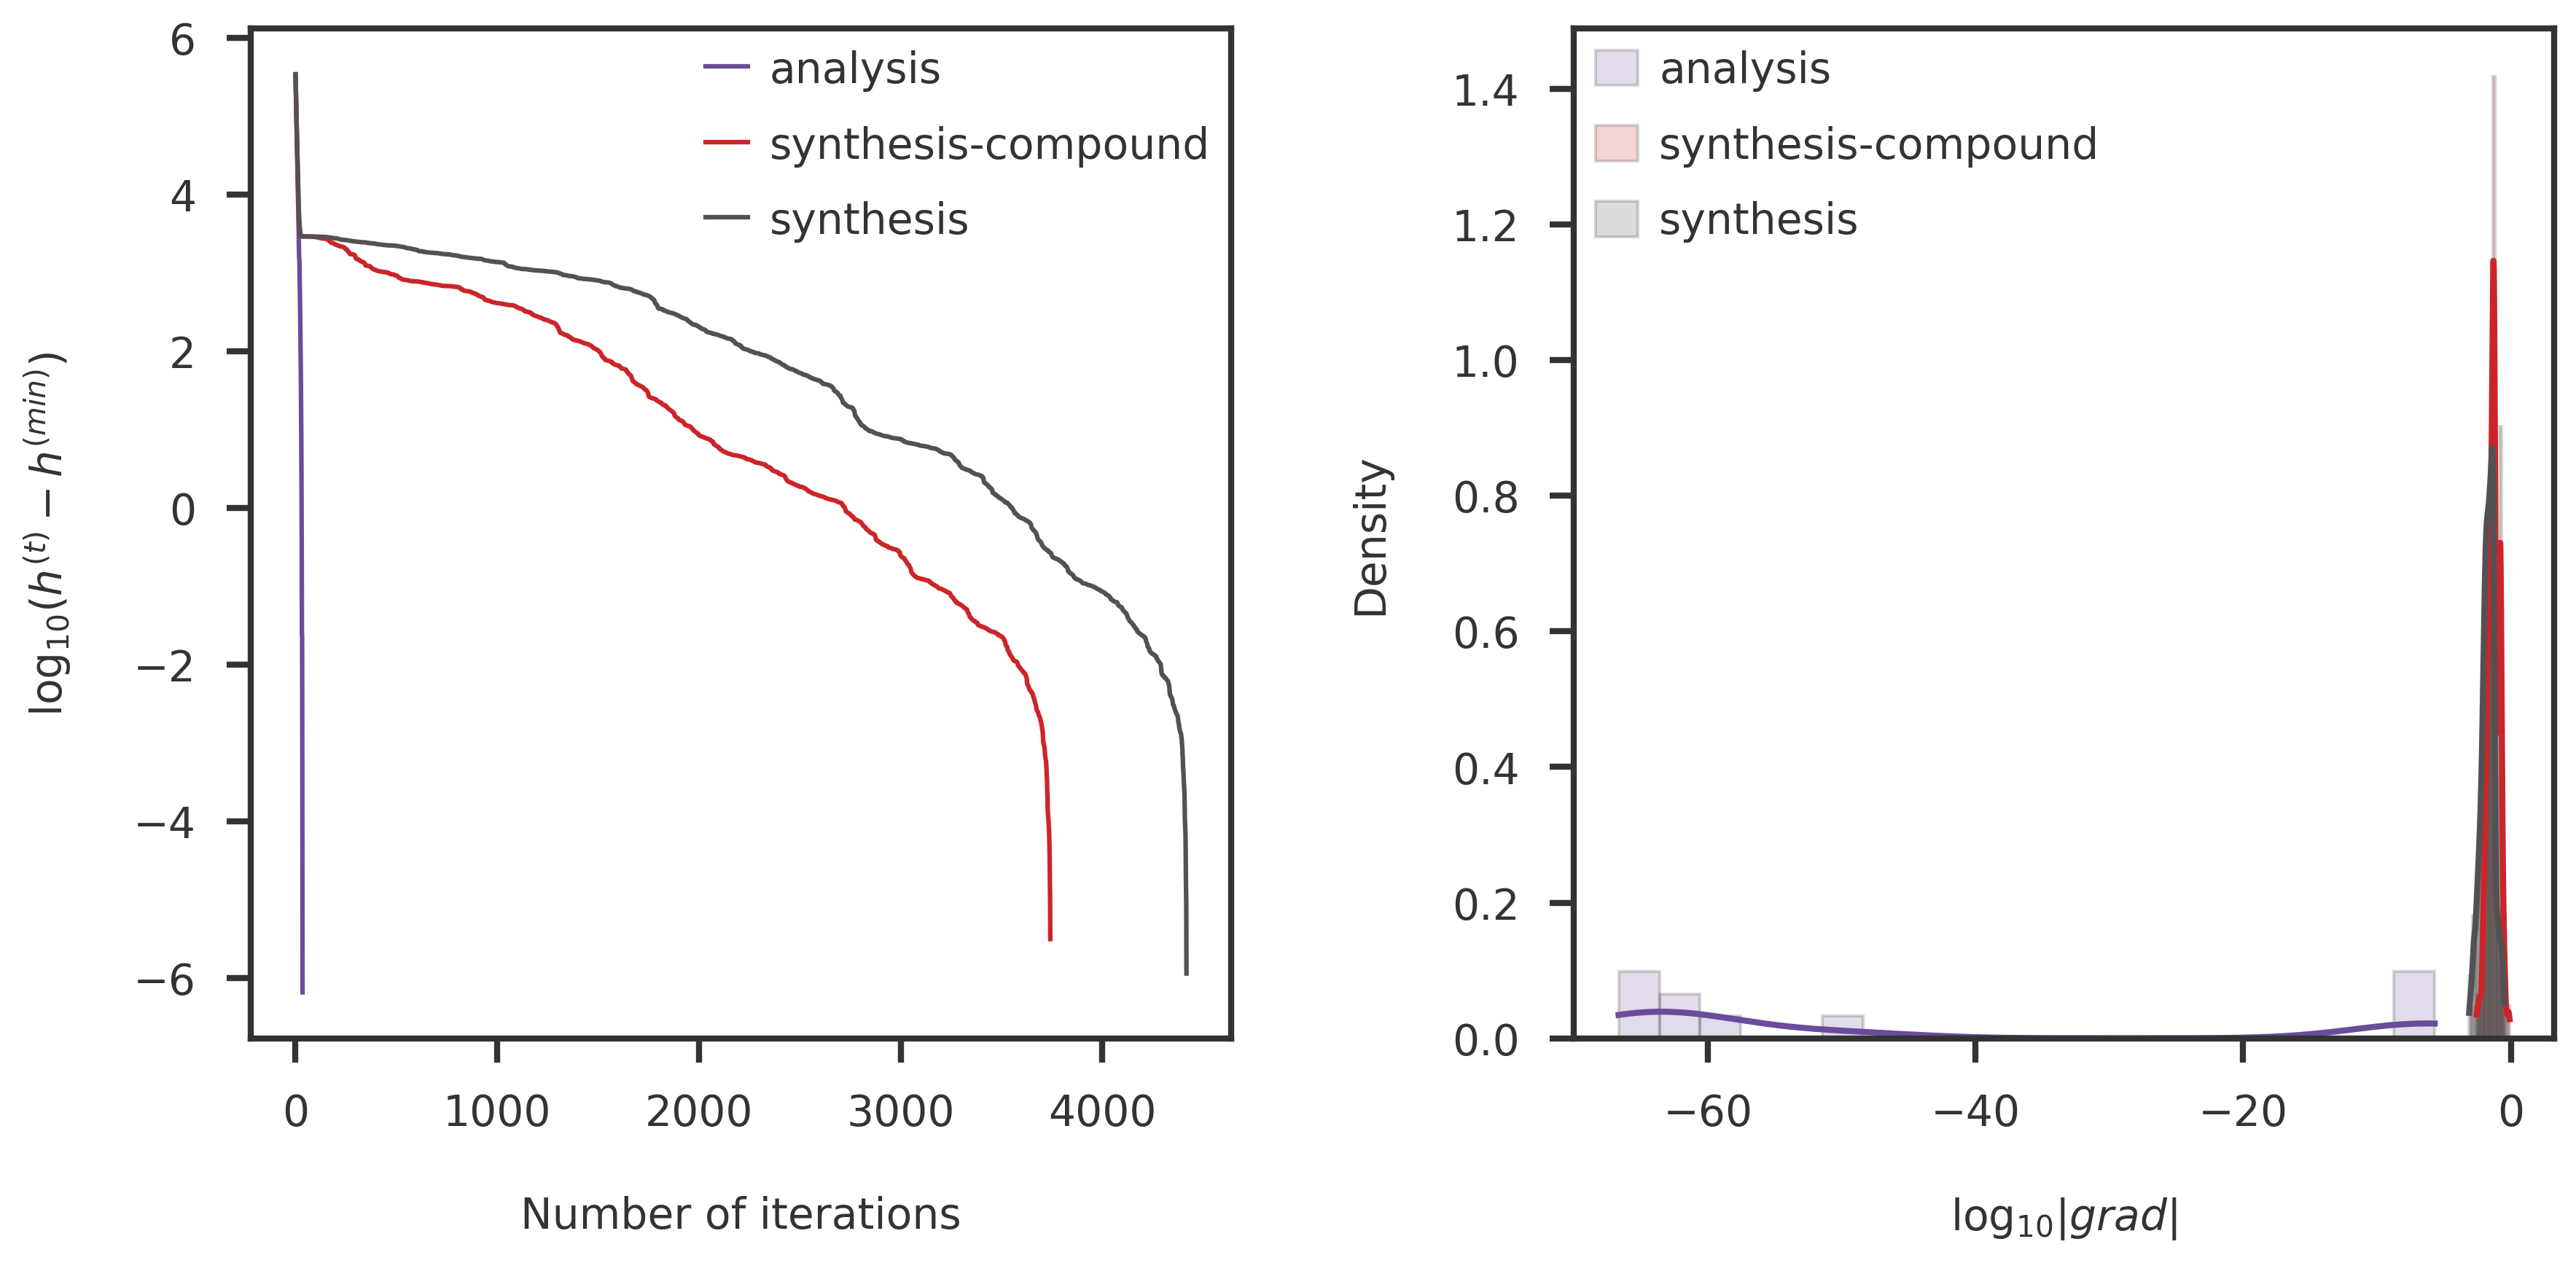

In [134]:
fig = plt.figure(figsize = (12, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

obj_min = np.min([gv1.obj.fun, gv2.obj.fun, gv3.obj.fun])

# ax1.plot(np.arange(gv1.obj.niter - 1), np.log10(gv1.obj.obj_path[:-1] - obj_min),
#          label = analysis')
# ax1.plot(np.arange(gv2.obj.niter - 1), np.log10(gv2.obj.obj_path[:-1] - obj_min),
#          label = 'synthesis-compound')
# ax1.plot(np.arange(gv3.obj.niter - 1), np.log10(gv3.obj.obj_path[:-1] - obj_min),
#          label = 'synthesis')
ax1.plot(np.arange(gv1.obj.niter - 1), np.log10(gv1.obj.obj_path[:-1] - gv1.obj.fun),
         color = method_colors['gradvi-wavelet'], label = 'analysis')
ax1.plot(np.arange(gv2.obj.niter - 1), np.log10(gv2.obj.obj_path[:-1] - gv2.obj.fun),
         color = method_colors['gradvi'], label = 'synthesis-compound')
ax1.plot(np.arange(gv3.obj.niter - 1), np.log10(gv3.obj.obj_path[:-1] - gv3.obj.fun),
         color = method_colors['gradvi-direct'], label = 'synthesis')
ax1.legend()
ax1.set_xlabel("Number of iterations")
ax1.set_ylabel(r"$\log_{10}(h^{(t)} - h^{(min)})$")

from scipy.stats import gaussian_kde as sp_gaussian_kde

def remove_outliers(data):
    quant3, quant1 = np.percentile(data, [75 ,25])
    iqr = quant3 - quant1
    xmin = quant1 - 1.5 * iqr
    xmax = quant3 + 1.5 * iqr
    Xkeep = np.array([x for x in data if (x >= xmin and x <= xmax)])
    return Xkeep

def density_plot(ax, data, label = '', color = 'k'):
    x = remove_outliers(data)
    xmin = np.min(x)
    xmax = np.max(x)
    kernel = sp_gaussian_kde(x)
    # smoothing
    kernel.covariance_factor = lambda : .2
    kernel._compute_covariance()
    
    xvals  = np.linspace(xmin, xmax, 200)
    density = kernel(xvals)
    ax.hist(x, density = True, label = label, color = color, alpha = 0.2)
    ax.plot(xvals, density, lw = 2, color = color)
    return
    
density_plot(ax2, np.log10(np.abs(gv1.obj.grad)), color = method_colors['gradvi-wavelet'], label = 'analysis')
density_plot(ax2, np.log10(np.abs(gv2.obj.grad)), color = method_colors['gradvi'], label = 'synthesis-compound')
density_plot(ax2, np.log10(np.abs(gv3.obj.grad)), color = method_colors['gradvi-direct'], label = 'synthesis')

# ax2.hist(np.log10(np.abs(gv1.obj.grad)), density = True, alpha = 0.5, label = 'analysis')
# ax2.hist(np.log10(np.abs(gv2.obj.grad)), density = True, alpha = 0.5, label = 'synthesis-compound')
# ax2.hist(np.log10(np.abs(gv3.obj.grad)), density = True, alpha = 0.5, label = 'synthesis')
ax2.legend()
ax2.set_ylabel("Density")
ax2.set_xlabel(r"$\log_{10}|grad|$")

#ax2.legend()
#mpl_utils.plot_diag(ax2)

fig.tight_layout()
fig.subplots_adjust(wspace=0.35)
# utils.saveplot(fig, 'trendfiltering_simple_examples_wavelet_moving_average_init_properties')
plt.show()

In [70]:
gv1.obj.fun

9001.43695199396

In [71]:
gv2.obj.fun

371.16162525880037

In [72]:
gv3.obj.fun

371.15951180725824

In [77]:
np.min(np.log10(np.abs(gv3.obj.grad)))

-64.24107416414702

In [82]:
np.where(np.abs(gv3.obj.grad) < 1e-30)

(array([512, 513, 514, 515, 516, 517, 518, 519, 520, 521]),)

In [52]:
np.log10(np.abs(gv3.obj.grad))

array([ -0.67862245,  -1.01247501,  -1.78369197,  -2.10794913,
        -1.49280061,  -1.82333964,  -1.86049083,  -1.83672231,
        -1.61977265,  -2.72202586,  -1.53730437,  -2.09821371,
        -1.93009969,  -1.62574338,  -2.04749235,  -1.96180116,
        -2.08368259,  -1.54726506,  -1.89771999,  -1.51401852,
        -1.81744133,  -2.33509232,  -3.43087776,  -1.75336906,
        -1.87403691,  -2.0186063 ,  -2.89060215,  -1.66999444,
        -1.8449306 ,  -2.02148255,  -1.57603813,  -2.15408536,
        -1.87484116,  -1.98332329,  -3.00585959,  -1.83502745,
        -2.15666796,  -3.39438855,  -1.96145832,  -2.33881252,
        -2.31880424,  -2.55239294,  -1.77340486,  -2.08596461,
        -3.40830068,  -2.30880201,  -1.91617142,  -1.98301152,
        -2.48275799,  -1.94270893,  -1.95849342,  -1.98419054,
        -1.77502107,  -1.90158646,  -2.82526164,  -1.76783066,
        -2.02532313,  -2.23019705,  -2.20865792,  -2.31642945,
        -2.14525559,  -1.95715332,  -3.52628972,  -2.20

In [5]:
run_methods = ['lasso', 'genlasso']

for method in run_methods:
    print (f"Running {method}")
    for dk, dv in data.items():
        print (f"    - Degree {dk}")
        res[method][dk] = tf_methods.factory(method, dv.y, dk)

Running lasso
    - Degree 0


R[write to console]: Loading required package: Matrix



    - Degree 1
    - Degree 2
Running genlasso
    - Degree 0
Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 

    - Degree 1
Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 

    - Degree 2
Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 



In [ ]:
from gradvi.models import basis_matrix
from gradvi.inference import WaveletRegression
from gradvi.tests import toy_priors
from gradvi.optimize.moving_average import moving_average

dk = 2
Hinv = basis_matrix.trendfiltering_inverse_scaled(n, dk)
H = basis_matrix.trendfiltering_scaled(n, dk)
dj = np.sum(np.square(H), axis = 0)


prior = toy_priors.get_ash_scaled(k = 10, sparsity = 0.9, skbase = (dk + 1) * 30.) 
#x0 = data[dk].ytrue
x0  = moving_average(data[dk].y, n = 40)
#x0 = data[dk].y
#x0 = res['genlasso'][dk].y
gv1 = WaveletRegression(maxiter = 1000, tol = 1e-8, display_progress = False)
# gv1.fit(Hinv, data[dk].y, prior, x_init = data[dk].ytrue, dj = dj)
# gv1.fit(Hinv, data[dk].y, prior, x_init = res['genlasso'][dk].y, dj = dj)
gv1.fit(Hinv, data[dk].y, prior, x_init = x0, dj = dj)